# 합성곱 신경망(CNN)
이미지, 음성 인식 등 다양한 곳에 상용됨.

## 전체 구조
* 기존: (Affine -> ReLu) => (Affine -> ReLu) => (Affine -> Softmax)
* CNN: (Conv -> ReLu -> Pooling) => (Conv -> ReLu -> Pooling) => (Affine -> ReLu) => (Affine -> Softmax)

## 합성곱 계층
* 패딩(padding)
* 스트라이드(sride)

### 완전연결 계층의 문제점
* '데이터의 형상이 무시'됨 
* 이미지는 3차원 형상이어서 공간적 정보가 담겨 있지만 형상을 무시하고 모든 입력 데이터를 동등한 뉴런(같은 차원의 뉴런)으로 취급하여 형상에 담긴 정볼르 살릴 수 없다.
* CNN에선 합성곱 계층의 입출력 데이터를 **특징 맵(feature map)**이라고 함.

### 합성곱 연산
* **합성곱 연산**: 이미지 처리에서 말하는 **필터 연산**
  * 필터의 **윈도우**를 일정 간격으로 이동해가며 입력 데이터에 적용한다.
* 필터는 문헌에 따라 커널이라 불리기도 한다.
* 편향도 포함할 수 있다.

### 패딩(padding)
* 입력 데이터 주위에 0을 채움
* 주로 출력 크기를 조정할 목적으로 사용됨
  * (4, 4)에 필터 (3, 3)을 적용하면 출력으로 (2, 2)크기의 특징 맵이 나오는데 합성곱 연산을 몇 번 반복하면 너무 작아지기 때문에 문제가 될 수 있다.
  * 입력 데이터의 공간적 크기를 고정한 채로 다음 계층에 전달할 수 있다.

### 스트라이드(stride)
* 윈도우가 이동하는 칸 수 
* 커지면 출력 크기가 작아진다.

### 3차원 데이터의 합성곱 연산
* 입력 데이터의 채널 수와 필터의 채널 수가 같아야 한다.
* 출력으로 다수의 채널을 내보내려면 필터(가중치)를 다수 사용하면 된다.

## 풀링(Pooling) 계층
* 세로 * 가로 방향의 공간을 줄이는 연산이다.
* 풀링의 윈도우 크기와 스트라이드는 같은 값으로 설정하는 것이 보통이다.
* 딥러닝 모델의 높은 정확도를 위해서 많은 필터를 사용하는데 이를 많이 사용하면 특징 맵이 늘어나고 이는 파라미터의 수를 늘린다. 이렇게 되면 오버피팅과 속도에 문제가 생길 수 있다. 때문에 차원의 크기를 감소시켜주기 위해 pooling 계층을 사용한다.
* 종류
  * 최대 풀링(max pooling): 해당 영역의 최댓값 계산
  * 평균 풀링(average pooling): 해당 영역의 평균값 계산
* 특징
  * 학습해야 할 매개변수가 없다.
  * 채널 수가 변하지 않는다.
  * 입력의 변화에 영향을 적게 받는다.
    * 입력 데이터가 조금 변해도 풀링 결과는 잘 변하지 않는다.

## 합성곱/풀링 계층 구현

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 4차원 배열

In [2]:
x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

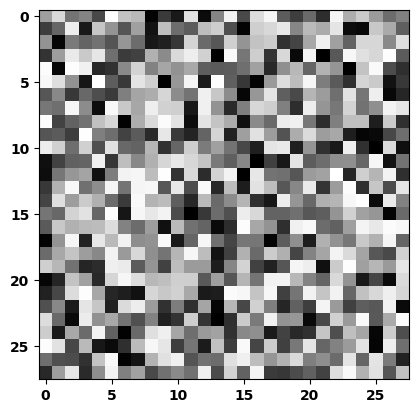

In [4]:
plt.imshow(x[0, 0], cmap='Greys')
plt.show()

### im2col
* 합성곱을 구현하려면 중첩 for문을 사용해야 하는데 이는 속도를 저하시킨다. 
* 이를 해 3차원의 데이터를 1차원으로 만들어 연산을 빠르게 하는게 목적이다.
* [자세한 설명](https://welcome-to-dewy-world.tistory.com/94)

## CNN 구현

In [7]:
from collections import OrderedDict
import sys, os
sys.path.append(os.pardir)

from common.layers import *

class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param = {'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        self.filter_num = conv_param['filter_num']
        self.filter_size = conv_param['filter_size']
        self.filter_pad = conv_param['pad']
        self.filter_stride = conv_param['stride']
        self.input_size = input_dim[1]
        self.conv_output_size = (self.input_size - self.filter_size + 2*self.filter_pad) / self.filter_stride + 1
        self.pool_output_size = int(self.filter_num * (self.conv_output_size/2) * (self.conv_output_size/2))

        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(self.filter_num, input_dim[0], self.filter_size, self.filter_size)
        self.params['b1'] = np.zeros(self.filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(self.pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        
        return grads

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)
        
        return acc / x.shape[0]

In [ ]:
from dataset.mnist import load_mnist
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

max_epochs=20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=1024,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

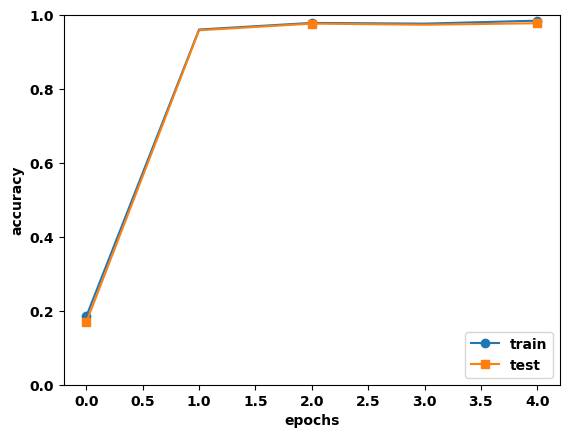

In [10]:
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(5)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


In [11]:
trainer.test_acc_list

[0.169, 0.959, 0.977, 0.974, 0.978]

In [16]:
import tensorflow as tf

# To use GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

```py
network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=1024,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()
```

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 5, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [36]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
x_train_tf = tf.constant(x_train.transpose(0, 2, 3, 1))
t_train_tf = tf.constant(t_train)
x_test_tf = tf.constant(x_test.transpose(0, 2, 3, 1))
t_test_tf = tf.constant(t_test)

In [38]:
history = model.fit(x_train_tf, t_train_tf, epochs=max_epochs, batch_size=32, validation_data=(x_test_tf, t_test_tf))

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1521 - accuracy: 0.9551 - val_loss: 0.0618 - val_accuracy: 0.9792
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0529 - accuracy: 0.9840 - val_loss: 0.0404 - val_accuracy: 0.9865
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0371 - accuracy: 0.9883 - val_loss: 0.0471 - val_accuracy: 0.9847
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0275 - accuracy: 0.9910 - val_loss: 0.0402 - val_accuracy: 0.9875
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0201 - accuracy: 0.9935 - val_loss: 0.0444 - val_accuracy: 0.9870
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0152 - accuracy: 0.9947 - val_loss: 0.0421 - val_accuracy: 0.9874
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0119 - accuracy: 0.9961 - val_loss: 0.0426 - val_accuracy:

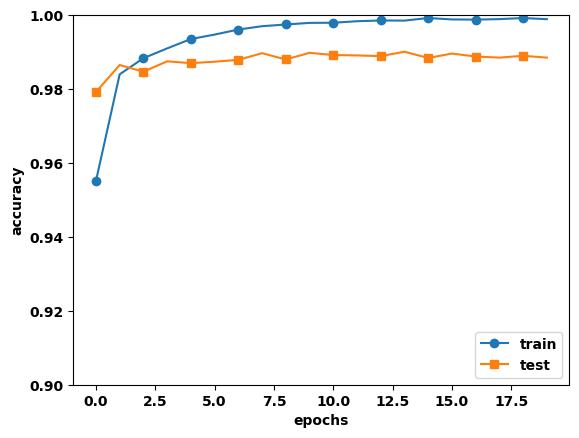

In [41]:
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, history.history['accuracy'], marker='o', label='train', markevery=2)
plt.plot(x, history.history['val_accuracy'], marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0.9, 1.0)
plt.legend(loc='lower right')
plt.show()
